In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import gdown
import os

file_id = "1WuKug4sbbvmNGrZ5PUaCUdw8tnM6xiqX"
out_path = "mnist_cnn_weights.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From: https://drive.google.com/uc?id=1WuKug4sbbvmNGrZ5PUaCUdw8tnM6xiqX
To: /home/onyxia/work/denoising-diffusion-model/reproducibility/mnist_cnn_weights.pth
100%|██████████| 1.01M/1.01M [00:00<00:00, 38.5MB/s]


In [5]:
import math
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt

class ForwardOU:
    
    def __init__(self, lambda_=1.0):
        self.lmbd = float(lambda_)

    def mean(self, x0, t):
        # t: [B]
        a = torch.exp(-self.lmbd * t)[:, None, None, None]
        return a * x0

    def std(self, t):
        # std(t) = sqrt(1 - exp(-2 lambda t))
        return torch.sqrt(1.0 - torch.exp(-2.0 * self.lmbd * t))[:, None, None, None]

    def diffusion_coeff(self, t):
        # g(t) = sqrt(2 lambda)  (constant for OU)
        return torch.full_like(t, math.sqrt(2.0 * self.lmbd))



In [6]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.lin1 = nn.Linear(dim, dim)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        """
        t: [B] in [0,1]
        returns: [B, dim]
        """
        half = self.dim // 2
        # sinusoidal features
        freqs = torch.exp(
            torch.arange(half, device=t.device, dtype=t.dtype)
            * (-math.log(10000.0) / (half - 1))
        )  # [half]
        args = t[:, None] * freqs[None, :]  # [B, half]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # [B, dim]
        # small MLP
        emb = self.lin1(emb)
        emb = self.act(emb)
        emb = self.lin2(emb)
        return emb


class ScoreNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.net = nn.Sequential(
            nn.Conv2d(1 + time_dim, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        emb = self.time_mlp(t)              # [B, time_dim]
        emb = emb[:, :, None, None]         # [B, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))
        inp = torch.cat([x, emb], dim=1)
        return self.net(inp)

@torch.no_grad()
def sample_reverse_euler_maruyama(
    model,
    sde: ForwardOU,
    num_steps=1000,
    batch_size=64,
    device="cuda",
    t_min=1e-3,
    img_size=28,
):

    model.eval()

    T = 1.0
    t_grid = torch.linspace(T, t_min, num_steps, device=device)  # decreasing

    # Start from approx N(0, 1) at t=T (OU marginal is close to std~1 for typical lambda/T).
    x = torch.randn(batch_size, 1, img_size, img_size, device=device)

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i + 1]
        dt = t_next - t_cur  # dt < 0

        t_batch = torch.full((batch_size,), t_cur, device=device)

        g = sde.diffusion_coeff(t_batch)          # [B]
        g2 = (g ** 2).view(batch_size, 1, 1, 1)   # [B,1,1,1]
        g = g.view(batch_size, 1, 1, 1)

        score = model(x, t_batch)                 # [B,1,28,28]
        drift = -sde.lmbd * x - g2 * score        # f - g^2 * score

        noise = torch.randn_like(x)
        x = x + drift * dt + g * torch.sqrt(-dt) * noise

    return x

def denorm(x):
    # [-1,1] -> [0,1]
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)

@torch.no_grad()
def show_samples(x, nrow=8, title="Samples"):
    x = denorm(x.detach().cpu())
    grid = vutils.make_grid(x, nrow=nrow, padding=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()




Loaded checkpoint.
time_dim: 64
lambda_ : 1.0


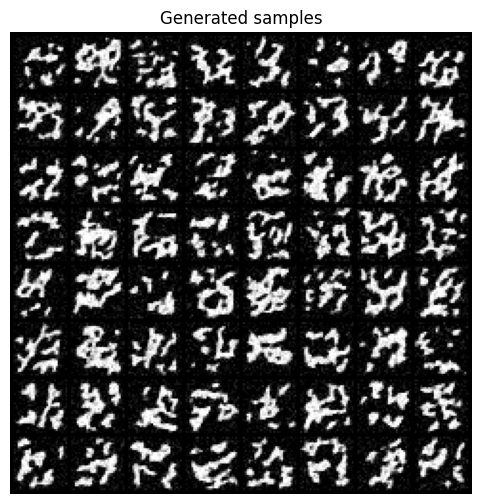

In [7]:
ckpt = torch.load(out_path, map_location=device)

# Try to recover hyperparams from checkpoint (fallback to defaults)
ckpt_cfg = ckpt.get("cfg", {}) or {}
time_dim = int(ckpt_cfg.get("time_dim", 64))
lambda_ = float(ckpt.get("sde_lambda", ckpt_cfg.get("lambda_", 1.0)))

print("Loaded checkpoint.")
print("time_dim:", time_dim)
print("lambda_ :", lambda_)

sde = ForwardOU(lambda_=lambda_)
model = ScoreNet(time_dim=time_dim).to(device)
model.load_state_dict(ckpt["model"])
model.eval()


samples = sample_reverse_euler_maruyama(
    model,
    sde,
    num_steps=1000,
    batch_size=64,
    device=device,
    t_min=1e-2,
    img_size=28,
)

show_samples(samples, nrow=8, title="Generated samples")